# Experiments

In [258]:
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np

import datasets
from learners import \
    OnlineGradientDescent, \
    DimensionFreeExponentiatedGradient, AdaptiveNormal,\
    KTCoinBetting, KTCoinBettingWithMarkovSideInformation, KTCoinBettingWithHint,\
    ContextTreeWeighting, \
    Addition, AddingVectorBettings, Mixture
from quantizer import Quantizer, get_standard_vector
from problems import LinearRegressionWithAbsoluteLoss

%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
problem = LinearRegressionWithAbsoluteLoss()

dataset = datasets.BeijingPM2pt5(
    root='../',
    standardize=True,
    rescale=False,
    bias=True,
    normalize=True,
    batch_normalize=False)
dim = dataset.X.shape[1]

# random permutation
X, y = dataset.X, dataset.y
data = X, y

In [260]:
X.shape

(43800, 7)

In [261]:
quantizer0 = Quantizer(quantizer_vector=get_standard_vector(dim, 0))

## Without side information

In [266]:
# OGD
ogds = dict()
# lr_scales = np.array([1.5 ** n for n in range(20)])  # cpuSmall, YPMSD
lr_scales = np.array([1.5 ** n for n in np.arange(15, 25)])  # Houses
for lr_scale in lr_scales:
    ogds[lr_scale] = OnlineGradientDescent(dim=dim, lr_scale=lr_scale, problem=problem).fit(data)
# DFEG
dfeg = DimensionFreeExponentiatedGradient(dim=dim, problem=problem).fit(data)
# AdaNorm
adanorm = AdaptiveNormal(dim=dim, problem=problem).fit(data)

In [264]:
init_wealth = 100

# KT coin betting
coin = KTCoinBetting(dim=dim, init_wealth=init_wealth, problem=problem).fit(data)

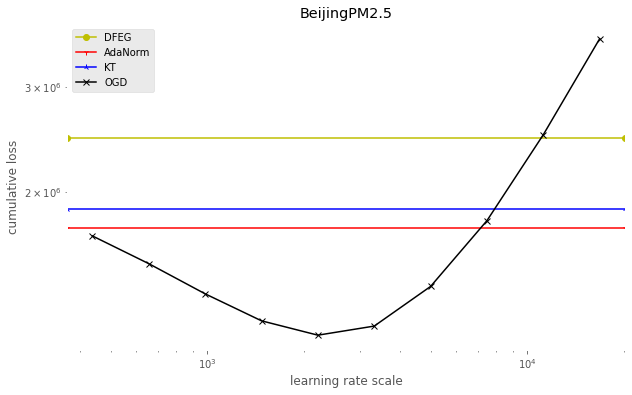

In [267]:
plt.axhline(dfeg.cum_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cum_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cum_loss, color='b', marker='2', label='KT')

plt.plot(lr_scales, [ogds[lr_scale].cum_loss for lr_scale in lr_scales], color='k', marker='x', label='OGD')
plt.xlabel('learning rate scale')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(dataset.name)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xscale('log')
plt.yscale('log')

## With side information

In [237]:
# with Markov side information
markovs = dict()
depths_markov = np.arange(0, 24, 2)
for depth in depths_markov:
    markovs[depth] = KTCoinBettingWithMarkovSideInformation(
        dim=dim,
        init_wealth=init_wealth,
        quantizer=quantizer0,
        depth=depth,
        problem=problem).fit(data)
    print(depth, end=' ')

0 2 4 6 8 10 12 14 16 18 20 22 

In [238]:
# with hint
coin_hint = KTCoinBettingWithHint(dim=dim,
                                  init_wealth=init_wealth,
                                  quantizer=quantizer0,
                                  problem=problem).fit(data)

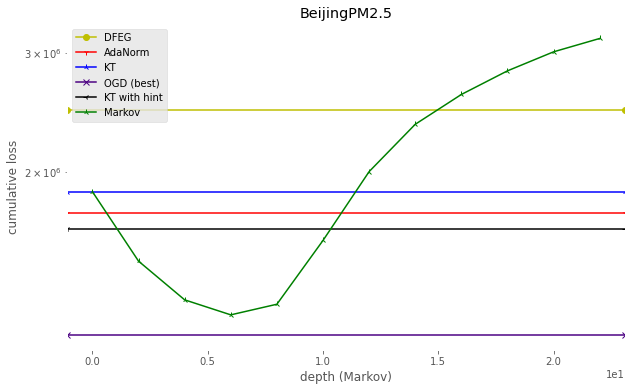

In [239]:
plt.axhline(dfeg.cum_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cum_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cum_loss, color='b', marker='2', label='KT')
plt.axhline(np.min([ogds[lr_scale].cum_loss for lr_scale in lr_scales]), color='indigo', marker='x', label='OGD (best)')

plt.axhline(coin_hint.cum_loss, color='k', marker='3', label='KT with hint')
plt.plot(depths_markov, [markovs[depth].cum_loss for depth in depths_markov],
         color='g', marker='2', label='Markov')
plt.xlabel('depth (Markov)')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(dataset.name)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.yscale('log')

0 2.5154666850003196
2 5.053655896999771
4 8.194900898000014
6 10.595377880999877
8 14.126763424999808
10 17.17128687100012
12 19.306267165999998
14 21.053009875000498
16 27.68506168299973
18 30.039767708
20 33.6124034860004
22 35.817547704999924


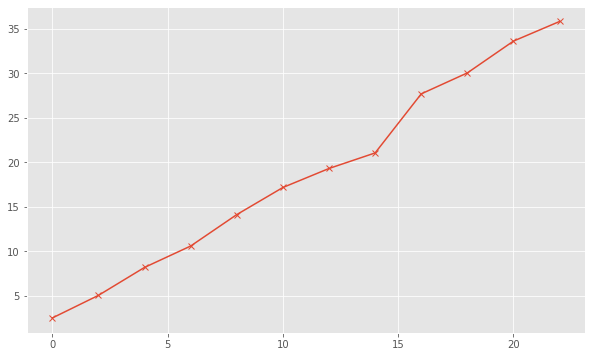

In [240]:
# with CTW
times = []
ctws = dict()
max_depths_ctw = np.arange(0, 24, 2)
for max_depth in max_depths_ctw:
    start = timer()
    ctws[max_depth] = ContextTreeWeighting(dim=dim,
                                           init_wealth=init_wealth,
                                           quantizer=quantizer0,
                                           max_depth=max_depth).fit(data)
    times.append(timer() - start)
    print(max_depth, times[-1])

plt.plot(max_depths_ctw, times, marker='x')

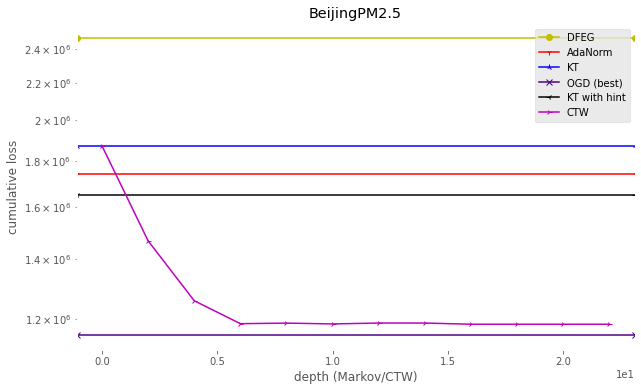

In [241]:
plt.axhline(dfeg.cum_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cum_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cum_loss, color='b', marker='2', label='KT')
plt.axhline(np.min([ogds[lr_scale].cum_loss for lr_scale in lr_scales]), color='indigo', marker='x', label='OGD (best)')

plt.axhline(coin_hint.cum_loss, color='k', marker='3', label='KT with hint')
plt.plot(max_depths_ctw, [ctws[max_depth].cum_loss for max_depth in max_depths_ctw],
         color='m', marker='4', label='CTW')
plt.xlabel('depth (Markov/CTW)')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(dataset.name)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.yscale('log')

## Combine algorithms

In [242]:
# adding Markov side information over dimension
depths_combine_markovs_dims = np.arange(1, 6)
add_markovs_over_dims = dict()
add_vec_markovs_over_dims = dict()
add_vec_markovs_over_dims_2 = dict()
mix_markovs_over_dims = dict()
for depth in depths_combine_markovs_dims:
    algorithms = [KTCoinBettingWithMarkovSideInformation(dim=dim,
                                                         init_wealth=init_wealth,
                                                         quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)),
                                                         depth=depth)
                  for i in range(dim)]
    add_markovs_over_dims[depth] = Addition(dim=dim, algorithms=algorithms).fit(data)
    add_vec_markovs_over_dims[depth] = AddingVectorBettings(dim=dim, algorithms=algorithms, init_wealth=init_wealth).fit(data)
    add_vec_markovs_over_dims_2[depth] = AddingVectorBettings(dim=dim, algorithms=algorithms, init_wealth=2*init_wealth).fit(data)
    mix_markovs_over_dims[depth] = Mixture(dim, algorithms, init_wealth=init_wealth, weights=None).fit(data)
    print(depth, end=' ')

1 2 3 4 5 

In [243]:
# adding/mixing Markov side information over depths
max_depths_combine_markovs_depths = range(1, 11)
add_markovs_over_depths = dict()
add_vec_markovs_over_depths = dict()
add_vec_markovs_over_depths_2 = dict()
mix_markovs_over_depths = dict()
for depth in max_depths_combine_markovs_depths:
    algorithms = [KTCoinBettingWithMarkovSideInformation(dim=dim,
                                                         init_wealth=init_wealth,
                                                         quantizer=quantizer0,
                                                         depth=d)
                  for d in range(depth)]
    add_markovs_over_depths[depth] = Addition(dim, algorithms).fit(data)
    add_vec_markovs_over_depths[depth] = AddingVectorBettings(dim, algorithms, init_wealth=init_wealth).fit(data)
    add_vec_markovs_over_depths_2[depth] = AddingVectorBettings(dim, algorithms, init_wealth=2*init_wealth).fit(data)
    mix_markovs_over_depths[depth] = Mixture(dim, algorithms, init_wealth=init_wealth, weights=None).fit(data)
    print(depth, end=' ')

1 2 3 4 5 6 7 8 9 10 

In [248]:
max_depths_combine_ctws_depths = range(1, 11)
add_ctws_over_depths = dict()
add_vec_ctws_over_depths = dict()
add_vec_ctws_over_depths_2 = dict()
mix_ctws_over_depths = dict()
for depth in max_depths_combine_ctws_depths:
    algorithms = [ContextTreeWeighting(dim=dim,
                                       init_wealth=init_wealth,
                                       quantizer=quantizer0,
                                       max_depth=d)
                  for d in range(depth)]
    add_ctws_over_depths[depth] = Addition(dim, algorithms).fit(data)
    # add_vec_ctws_over_depths[depth] = AddingVectorBettings(dim, algorithms, init_wealth=init_wealth).fit(data)
    # add_vec_ctws_over_depths_2[depth] = AddingVectorBettings(dim, algorithms, init_wealth=2*init_wealth).fit(data)
    mix_ctws_over_depths[depth] = Mixture(dim, algorithms, init_wealth=init_wealth, weights=None).fit(data)
    print(depth, end=' ')

1 2 3 4 5 6 7 8 9 10 

In [249]:
add_ctws_over_dims = dict()
add_vec_ctws_over_dims = dict()
mix_ctws_over_dims = dict()

for max_depth in max_depths_combine_ctws_depths:
    algorithms = [ContextTreeWeighting(dim=dim,
                                       init_wealth=init_wealth,
                                       quantizer=Quantizer(get_standard_vector(dim, i)),
                                       max_depth=max_depth)
                  for i in range(dim)]
    add_ctws_over_dims[max_depth] = Addition(dim, algorithms).fit(data)
    add_vec_ctws_over_dims[max_depth] = AddingVectorBettings(dim, algorithms, init_wealth=init_wealth).fit(data)
    mix_ctws_over_dims[max_depth] = Mixture(dim, algorithms, init_wealth=init_wealth, weights=None).fit(data)
    print(max_depth, end=' ')

1 2 3 4 5 6 7 8 9 10 

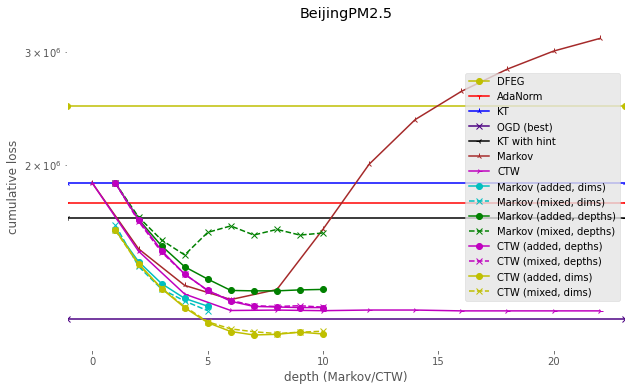

In [256]:
plt.axhline(dfeg.cum_loss, color='y', marker='o', label='DFEG')
plt.axhline(adanorm.cum_loss, color='r', marker='1', label='AdaNorm')
plt.axhline(coin.cum_loss, color='b', marker='2', label='KT')
plt.axhline(np.min([ogds[lr_scale].cum_loss for lr_scale in lr_scales]), color='indigo', marker='x', label='OGD (best)')

plt.axhline(coin_hint.cum_loss, color='k', marker='3', label='KT with hint')
plt.plot(depths_markov, [markovs[depth].cum_loss for depth in depths_markov],
         color='brown', marker='2', label='Markov')
plt.plot(max_depths_ctw, [ctws[max_depth].cum_loss for max_depth in max_depths_ctw],
         color='m', marker='4', label='CTW')

plt.plot(depths_combine_markovs_dims, [add_markovs_over_dims[depth].cum_loss for depth in depths_combine_markovs_dims],
         color='c', marker='o', label='Markov (added, dims)')
# plt.plot(depths_combine_markovs_dims, [add_vec_markovs_over_dims[depth].cum_loss for depth in depths_combine_markovs_dims],
#          color='c', marker='v', label='Markov (vec. added, dims)')
# plt.plot(depths_combine_markovs_dims, [add_vec_markovs_over_dims_2[depth].cum_loss for depth in depths_combine_markovs_dims],
#          color='c', marker='^', linestyle='--', label='Markov (vec. added, dims, 2)')
plt.plot(depths_combine_markovs_dims, [mix_markovs_over_dims[depth].cum_loss for depth in depths_combine_markovs_dims],
         color='c', marker='x', linestyle='--', label='Markov (mixed, dims)')

plt.plot(max_depths_combine_markovs_depths, [add_markovs_over_depths[max_depth].cum_loss
                                             for max_depth in max_depths_combine_markovs_depths],
         color='g', marker='o', label='Markov (added, depths)')
# plt.plot(max_depths_combine_markovs_depths, [add_vec_markovs_over_depths[max_depth].cum_loss
#                                              for max_depth in max_depths_combine_markovs_depths],
#          color='g', marker='v', label='Markov (vec. added, depths)')
# plt.plot(max_depths_combine_markovs_depths, [add_vec_markovs_over_depths_2[max_depth].cum_loss
#                                              for max_depth in max_depths_combine_markovs_depths],
#          color='g', marker='^', linestyle='--', label='Markov (vec. added, depths, 2)')
plt.plot(max_depths_combine_markovs_depths, [mix_markovs_over_depths[max_depth].cum_loss
                                                  for max_depth in max_depths_combine_markovs_depths],
         color='g', marker='x', linestyle='--', label='Markov (mixed, depths)')

plt.plot(max_depths_combine_ctws_depths, [add_ctws_over_depths[depth].cum_loss for depth in max_depths_combine_ctws_depths],
         color='m', marker='o', label='CTW (added, depths)')
# plt.plot(max_depths_combine_ctws_depths, [add_vec_ctws_over_depths[depth].cum_loss for depth in max_depths_combine_ctws_depths],
#          color='m', marker='v', label='CTW (vec. added, depths)')
# plt.plot(max_depths_combine_ctws_depths, [add_vec_ctws_over_depths_2[depth].cum_loss for depth in max_depths_combine_ctws_depths],
#          color='m', marker='^', linestyle='--', label='CTW (vec. added, depths, 2)')
plt.plot(max_depths_combine_ctws_depths, [mix_ctws_over_depths[depth].cum_loss for depth in max_depths_combine_ctws_depths],
         color='m', marker='x', linestyle='--', label='CTW (mixed, depths)')

plt.plot(max_depths_combine_ctws_depths, [add_ctws_over_dims[depth].cum_loss for depth in max_depths_combine_ctws_depths],
         color='y', marker='o', label='CTW (added, dims)')
# plt.plot(max_depths_combine_ctws_depths, [add_vec_ctws_over_dims[depth].cum_loss for depth in max_depths_combine_ctws_depths],
#          color='y', marker='v', label='CTW (vec. added, dims)')
# plt.plot(max_depths_combine_ctws_depths, [add_vec_ctws_over_dims_2[depth].cum_loss for depth in max_depths_combine_ctws_depths],
#          color='y', marker='^', linestyle='--', label='CTW (vec. added, dims, 2)')
plt.plot(max_depths_combine_ctws_depths, [mix_ctws_over_dims[depth].cum_loss for depth in max_depths_combine_ctws_depths],
         color='y', marker='x', linestyle='--', label='CTW (mixed, dims)')

plt.xlabel('depth (Markov/CTW)')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(dataset.name)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.yscale('log')
# plt.ylim([4.5*10**4, 7.5*10**4])

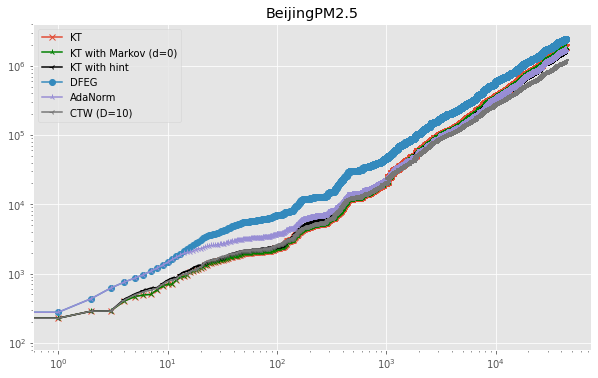

In [257]:
T = dataset.X.shape[0]
ts = np.arange(1, T+1)
plt.plot(coin.losses.cumsum(), 'x-', label='KT')
plt.plot(markovs[depths_markov[0]].losses.cumsum(), color='g', marker='2', label='KT with Markov (d={})'.format(depths_markov[0]))
plt.plot(coin_hint.losses.cumsum(), color='k', marker='3', label='KT with hint')
plt.plot(dfeg.losses.cumsum(), 'o-', label='DFEG')
plt.plot(adanorm.losses.cumsum(), '2-', label='AdaNorm')
plt.plot(ctws[max_depths_ctw[5]].losses.cumsum(), '3-', label='CTW (D={})'.format(max_depths_ctw[5]))
# plt.plot(add_markovs_over_depths[max_depths_combine_markovs_depths[4]].losses.cumsum(), '4-', label='Added Markov (D={})'.format(max_depths_combine_markovs_depths[4]))
# plt.plot(add_ctws_over_depths[max_depths_combine_ctws_depths[4]].losses.cumsum(), '4-', label='Added CTW (D={})'.format(max_depths_combine_ctws_depths[4]))
# plt.plot(mix_markovs_over_depths[max_depths_combine_markovs_depths[4]].losses.cumsum(), '4-', label='Mixed Markov (D={})'.format(max_depths_combine_markovs_depths[4]))
# plt.plot(mix_ctws_over_depths[max_depths_combine_ctws_depths[4]].losses.cumsum(), '4-', label='Mixed CTW (D={})'.format(max_depths_combine_ctws_depths[4]))
# plt.plot(add_ctws_over_dims[max_depths_combine_ctws_depths[4]].losses.cumsum(), '4-', label='Addd CTW (dim={})'.format(max_depths_combine_ctws_depths[4]))
plt.title(dataset.name)
# plt.xlim([10**2, 10**4])
# plt.ylim([10**3, 10**5])
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
# Follow the leading history (for nonstationary problem)
# How does a new expert get assigned?
# History: 1101
# how to combine experts with history of different length
# Ensemble with random draw
# Boosting?